# Churn Model for a Telecommunciations Company

In [161]:
## Importing relevant libraries
import pandas as pd
import numpy as np

# Plotting
import os
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
from itertools import product
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
# ML
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import xgboost as xgb
from sklearn.metrics import roc_auc_score

## Model 2

In [182]:
# Import Data
churn_df = pd.read_excel("churn.xlsx")

In [183]:
churn_df

,Call_Failure,Complains,Subscription_Length,Seconds_of_Use,Frequency_of_use,Frequency_of_SMS,Distinct_Called_Numbers,Age_Group,Age,Churn
0,8,0,38,4370,71,5,17,3,30,0
1,0,0,39,318,5,7,4,2,25,0
2,10,0,37,2453,60,359,24,3,30,0
3,10,0,38,4198,66,1,35,1,15,0
4,3,0,38,2393,58,2,33,1,15,0
...,...,...,...,...,...,...,...,...,...,...
3145,21,0,19,6697,147,92,44,2,25,0
3146,17,0,17,9237,177,80,42,5,55,0
3147,13,0,18,3157,51,38,21,3,30,0
3148,7,0,11,4695,46,222,12,3,30,0


In [184]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Call_Failure             3150 non-null   int64
 1   Complains                3150 non-null   int64
 2   Subscription_Length      3150 non-null   int64
 3   Seconds_of_Use           3150 non-null   int64
 4   Frequency_of_use         3150 non-null   int64
 5   Frequency_of_SMS         3150 non-null   int64
 6   Distinct_Called_Numbers  3150 non-null   int64
 7   Age_Group                3150 non-null   int64
 8   Age                      3150 non-null   int64
 9   Churn                    3150 non-null   int64
dtypes: int64(10)
memory usage: 246.2 KB


In [185]:
# luckily we don't have any missing data!

array([[<Axes: title={'center': 'Call_Failure'}>,
        <Axes: title={'center': 'Complains'}>,
        <Axes: title={'center': 'Subscription_Length'}>],
       [<Axes: title={'center': 'Seconds_of_Use'}>,
        <Axes: title={'center': 'Frequency_of_use'}>,
        <Axes: title={'center': 'Frequency_of_SMS'}>],
       [<Axes: title={'center': 'Distinct_Called_Numbers'}>,
        <Axes: title={'center': 'Age_Group'}>,
        <Axes: title={'center': 'Age'}>],
       [<Axes: title={'center': 'Churn'}>, <Axes: >, <Axes: >]],
      dtype=object)

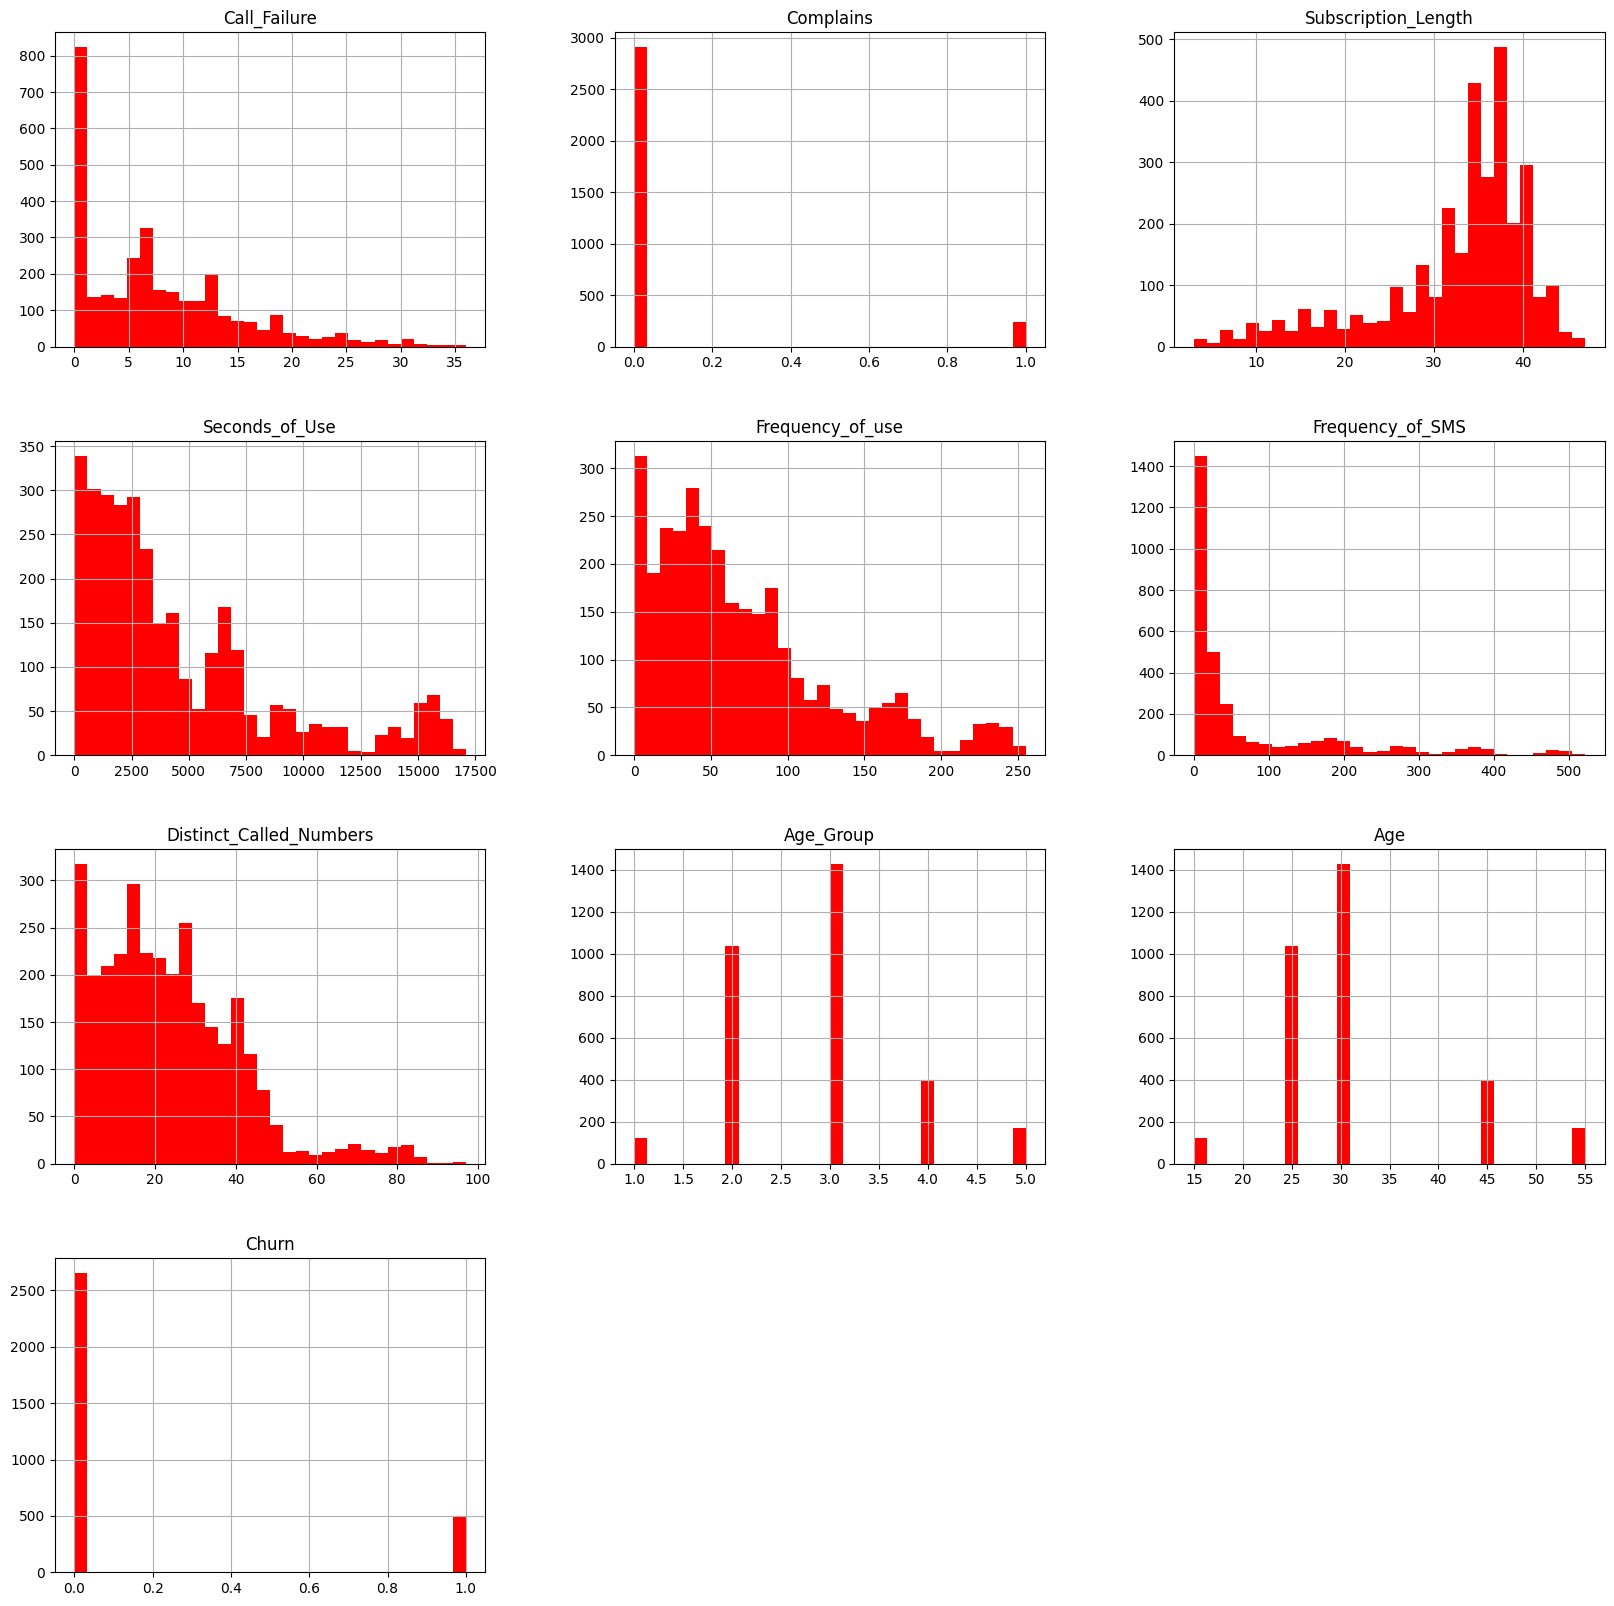

In [186]:
churn_df.hist(bins = 30, figsize = (20,20), color = 'r')

**Findings:** We notice that the dataset is unblanced. To avoid hampering with the ML process, we will downscale the training data

<Axes: >

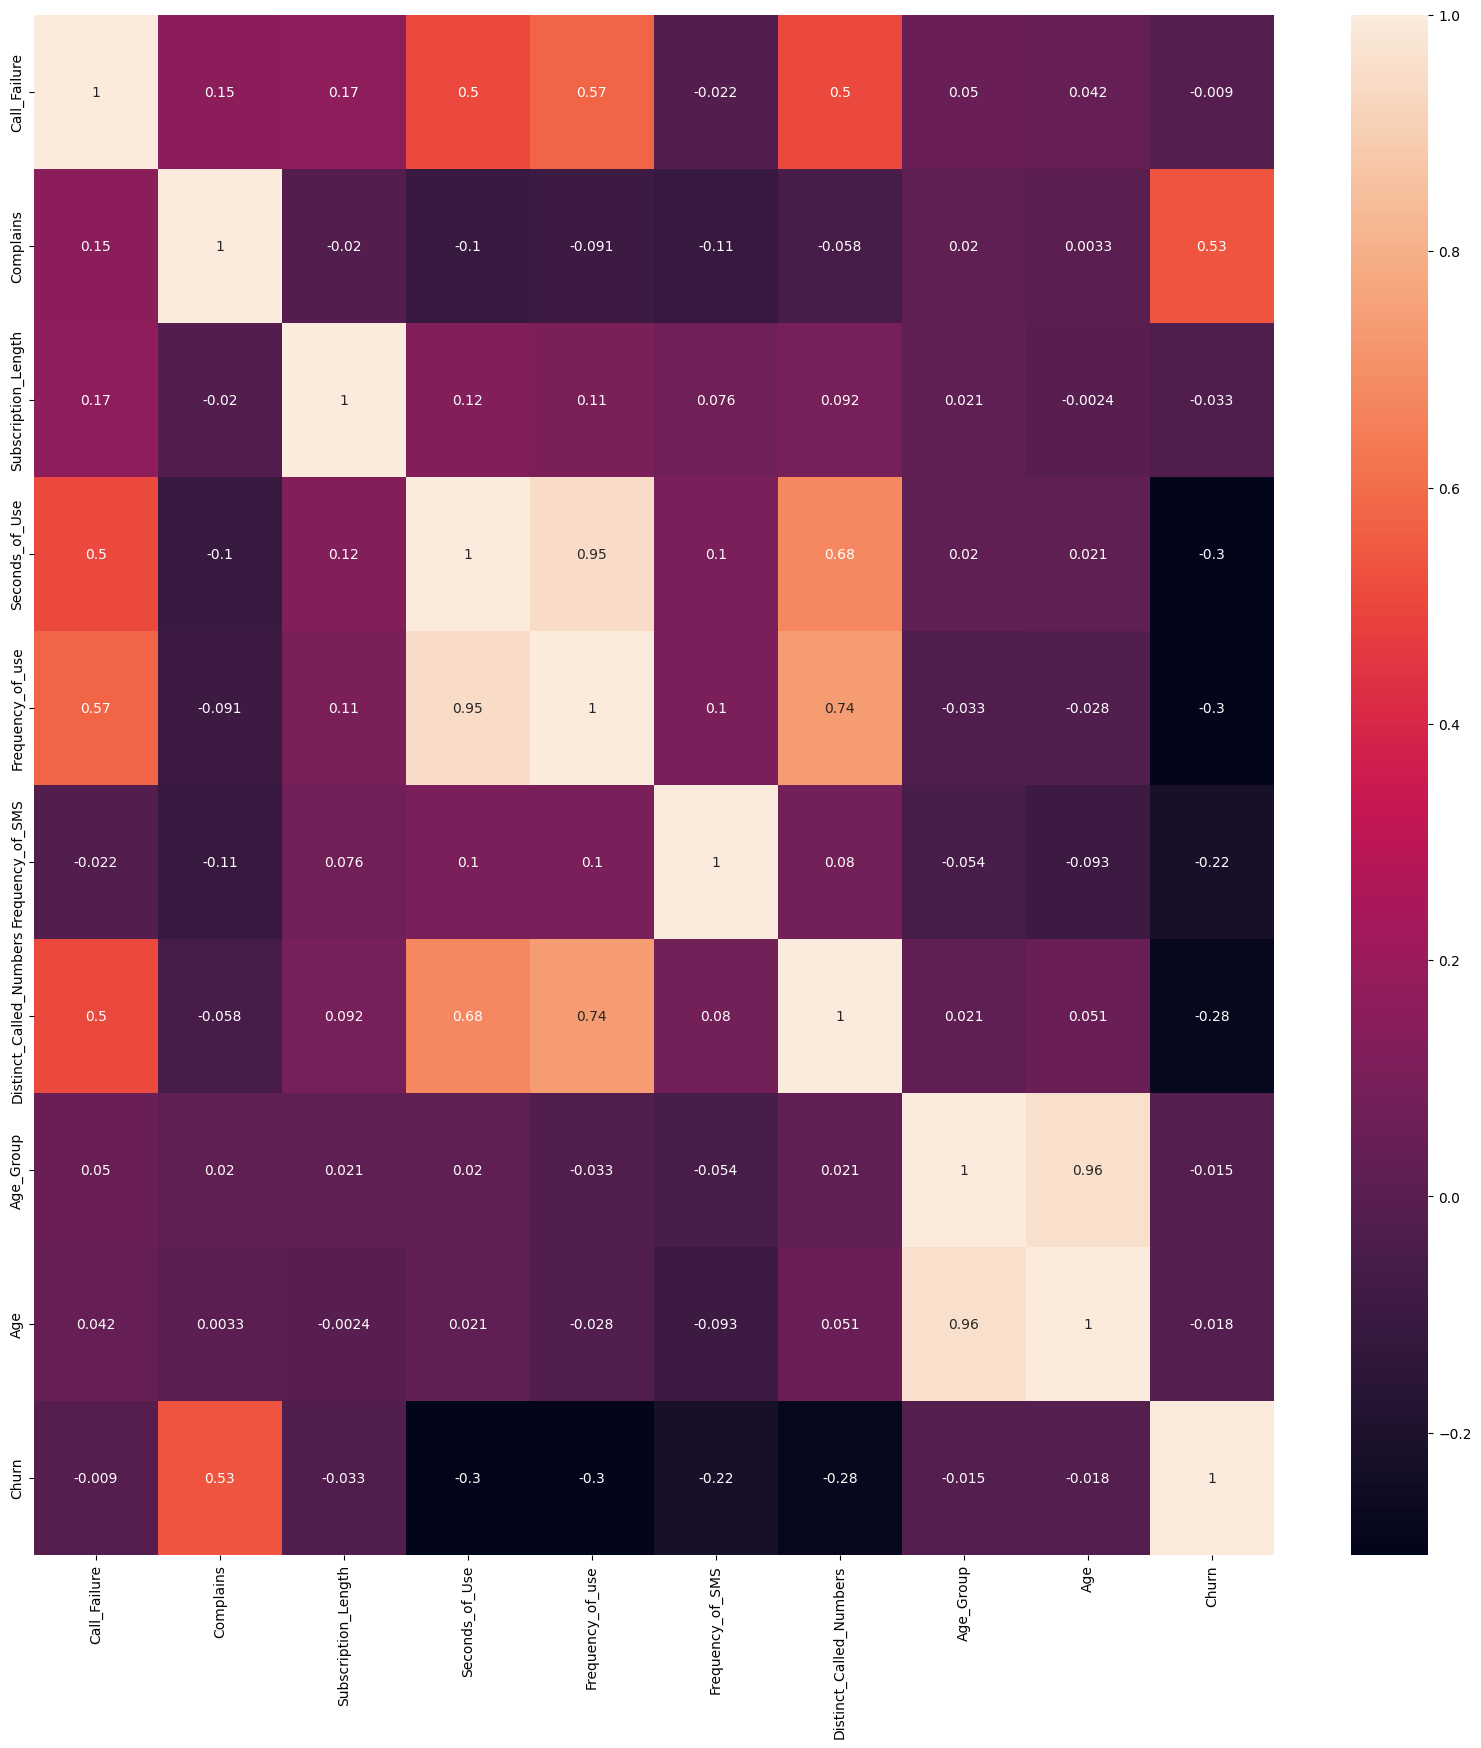

In [187]:
correlations = churn_df.corr()
f, ax = plt.subplots(figsize = (20, 20))
sns.heatmap(correlations, annot = True)

**Observations:** There are number of highly correlated features, which will be omitted:
- Age Group and Age are highly correlated and repetitve. We will drop Age Group, since no infromation was provided how these age groups are structured
- Frequency of Use and Seconds of Use are also highly correlated. Frequency of Use is more intutive of a metric, thus we will drop Seconds of Use

In [188]:
churn_df = churn_df.drop(["Age_Group","Seconds_of_Use"], axis=1)

In [189]:
# Feature and Label Split
X = churn_df.drop("Churn", axis=1)
y = churn_df["Churn"]

In [190]:
# Train and Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=99)

In [191]:
from sklearn.utils import resample
# Downsample Training Dats
# Concatenate X_train and y_train into a single DataFrame
df_train = pd.concat([X_train, y_train], axis=1)

# Separate the majority and minority classes
majority_class = df_train[df_train[y_train.name] == 0]
minority_class = df_train[df_train[y_train.name] == 1]

# Calculate the desired number of samples for the majority class
desired_count = len(minority_class)

# Randomly undersample the majority class
majority_downsampled = resample(majority_class, replace=False, n_samples=desired_count, random_state=99)

# Combine the downsampled majority class and the minority class
df_balanced_train = pd.concat([majority_downsampled, minority_class])

# Split the balanced DataFrame back into X_train and y_train
X_train = df_balanced_train.drop(columns=[y_train.name])
y_train = df_balanced_train[y_train.name]


In [192]:
#Scale Data 
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [193]:
# Create an XGBoost classifier
xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',  # Logarithmic loss
    use_label_encoder=False,  # To avoid warnings about deprecated label encoder
    random_state=42
)

In [194]:
# Define a parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}


In [195]:
# Create a GridSearchCV object with ROC AUC as the scoring metric
grid_search = GridSearchCV(xgb_classifier, param_grid, scoring='roc_auc', cv=5, n_jobs=-1)

# Perform grid search on the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Train an XGBoost model with the best hyperparameters
best_xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    **best_params
)
best_xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [196]:
# Predict on the test set
y_pred = best_xgb_model.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred)

# Output the results
print("Best Hyperparameters:", best_params)
print("Test Set ROC AUC Score:", roc_auc)

Best Hyperparameters: {'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}
Test Set ROC AUC Score: 0.8981305449936628


In [154]:
import pickle

# Your trained machine learning model
model = best_xgb_model

# Specify the file path to save the model
model_file_path = 'churn_model_5.pkl'

# Open the file in binary write mode
with open(model_file_path, 'wb') as model_file:
    pickle.dump(model, model_file)

In [155]:
scaler_file_path = 'scaler_churn_5.pkl'
with open(scaler_file_path, 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)